# **Assignment-3 : Generalization ability of SVM classification based on Markov Sampling**

Group Members : 

IIT2018114 Harsh Goyal \
IIT2018144 Aaditya Gadhave \
IIT2018149 Sourabh Gupta \
IIT2018158 Meet Singh Gambhir \
IIT2018159 Tushar Atrey


**1. Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
import numpy.linalg as npla
import random

from functools import partial
import pylab

In [ ]:
data = pd.read_csv("letter-recognition.csv")
data.columns = ['letter', 
                'xbox'  , 
                'ybox'  , 
                'width' , 
                'height', 
                'onpix' , 
                'xbar'  ,
                'ybar'  , 
                'x2bar' , 
                'y2bar' , 
                'xybar' , 
                'x2ybar', 
                'xy2bar', 
                'xedge' ,
                'xedgey', 
                'yedge' , 
                'yedgex']
order = list(np.sort(data['letter'].unique()))
random_state = 100

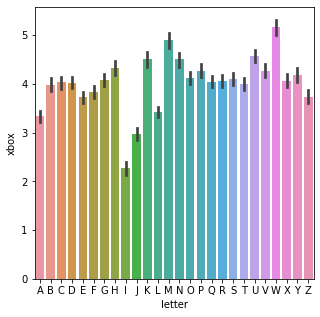

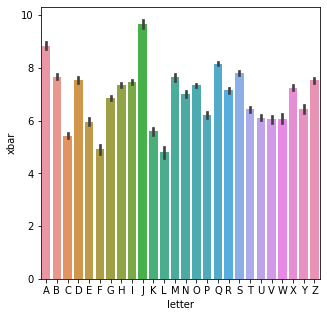

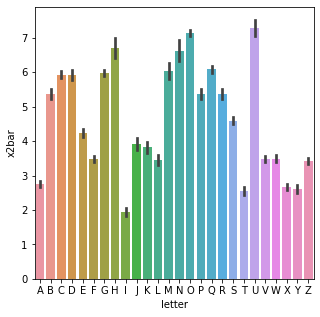

In [ ]:
plt.figure(figsize=(5, 5))
sns.barplot(x='letter',
            y='xbox', 
            data=data, 
            order=order)

plt.figure(figsize=(5, 5))
sns.barplot(x='letter', 
            y='xbar', 
            data=data, 
            order=order)

plt.figure(figsize=(5, 5))
sns.barplot(x='letter', 
            y='x2bar', 
            data=data, 
            order=order)

In [ ]:
attribute_mean = data.groupby('letter').mean()
attribute_mean.head()

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
letter,,,,,,,,,,,,,,,,
A,3.337136,6.975919,5.128010,5.178707,2.991128,8.851711,3.631179,2.755387,2.043093,7.802281,2.338403,8.465146,2.771863,6.321926,2.875792,7.468948
B,3.985640,6.962141,5.088773,5.169713,4.596606,7.671018,7.062663,5.366841,5.571802,7.954308,5.506527,6.652742,3.117493,7.919060,6.612272,9.100522
C,4.031250,7.063859,4.701087,5.296196,2.775815,5.437500,7.627717,5.927989,7.177989,8.773098,7.494565,11.947011,1.991848,8.876359,4.080163,8.555707
D,4.023602,7.244720,5.170186,5.288199,4.026087,7.539130,6.806211,5.921739,6.508075,8.166460,5.111801,5.750311,3.365217,7.813665,3.971429,7.628571
E,3.727865,6.944010,4.756510,5.201823,3.679688,5.966146,7.352865,4.223958,7.585938,8.507812,6.242188,10.341146,2.127604,8.298177,6.022135,8.506510


In [ ]:
round(data.drop('letter', axis=1).mean(), 2)

xbox      4.02
ybox      7.04
width     5.12
height    5.37
onpix     3.51
xbar      6.90
ybar      7.50
x2bar     4.63
y2bar     5.18
xybar     8.28
x2ybar    6.45
xy2bar    7.93
xedge     3.05
xedgey    8.34
yedge     3.69
yedgex    7.80
dtype: float64

In [ ]:
X = data.drop("letter", axis = 1)
Y = data['letter']

X_scaled = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = random_state)

In [ ]:

def gaussian(x, sigma, sampled=None):
    if sampled is None: 
        L = npla.cholesky(sigma)
        z = np.random.randn(x.shape[0], 1)
        return np.dot(L, z+x)
    else:
        a = x - sampled
        b = np.dot(npla.inv(sigma), a)

        return np.exp(-0.5*np.dot( a.T, b))[0,0]


def gaussian_1d(x, sigma, sampled=None):
    if sampled is None:
        return sigma*np.random.randn(1)[0]
    else:
        return np.exp(-0.5( (x-sampled)**2)/sigma**2)


def chi_sq(x, sampled = None, n = 0):
    if sampled is None:
        return np.random.chisquare(n)
    else:
        return np.power(sampled,0.5*n - 1)*np.exp(-0.5*sampled)


def inv_chi_sq(theta, n, a):
    return np.power(theta, -0.5*n)*np.exp(-a/(2*theta))


def metropolis(f, proposal, old):
    new = proposal(old)
    alpha = np.min([f(new)/f(old), 1])
    u = np.random.uniform()
    cnt = 0
    if (u < alpha):
        old = new
        cnt = 1
    return old, cnt


def met_hast(f, proposal, old):
    new = proposal(old)
    a = proposal(new, sampled = old)
    b = proposal(old, sampled = new)
    alpha = np.min([(f(new)*a)/(f(old) * b), 1])
    u = np.random.uniform()
    cnt = 0
    if (u < alpha):
        old = new
        cnt = 1
    return old, cnt

def run_chain(chainer, f, proposal, start, n, take=1):
    count = 0
    samples = [start]
    for i in range(n):
        start, c = chainer(f, proposal, start)
        count = count + c
        if i%take is 0:
            samples.append(start)
    return samples, count

def uni_prop(x, frm, to, sampled=None):
    return np.random.uniform(frm, to)



## Model Building
Let's fist build two basic models - linear and non-linear with default hyperparameters, and compare the accuracies.

In [ ]:
print((y_train.to_numpy()))

['D' 'I' 'W' ... 'Q' 'V' 'Y']


In [ ]:
def markov_samp(X_train, Y_train, k = 5, q = 1.2):

    InitialSample = np.concatenate((np.vstack(X_train), np.vstack(Y_train.to_numpy())), axis = 1)
    Dtr = random.sample(list(InitialSample), 2000)

    m = len(Dtr)
    print("M : " , m)
    mneg, mplus = 0, 0

    index = np.random.choice(len(Dtr), 1, replace=False)  
    Dtra = np.array(Dtr)
    print(type(Dtra))
    zt = Dtra[index][0]
    print("zt : ", zt)
    if m%2 == 0:
        if zt[16] == 'A':
            mplus += 1;
        else:
            mneg += 1
    sample = []
    Pd, Pdd = 0, 0
    print(zt)
    while(mplus + mneg < m ):
        zstar = Dtra[np.random.choice(len(Dtr), 1, replace=False)][0]
        P = 1
        yt = zt[16]
        zt = zstar
        if P == 1:
            if zt[16] == yt:
                sample.append(zstar) 
            else:
                sample.append(zstar) 

        if len(sample) == k:
            Pdd = q*P
            sample.append(zstar)
            
        ztp1 = zstar
        if yt == 'A':
            mplus += 1
        else:
            mneg += 1

        if P > 1 or Pd > 1 or Pdd > 1:
            sample.append(zstar)
    return sample


In [ ]:
nsamp = np.array(markov_samp(X_train, y_train))
print(nsamp.shape)
X_train = nsamp[:, 0:16]
y_train = nsamp[:, 16]
print(X_train.shape)
print(y_train.shape)


M :  2000
<class 'numpy.ndarray'>
zt :  ['-0.535058351189197' '0.897111492873891' '-0.5569354208653187'
 '0.7197043272227955' '-1.1440792055116078' '3.505618739092575'
 '-2.7957398671014135' '0.8782855643399382' '-0.07502005433265674'
 '2.2977752670493605' '-2.0729475398212043' '0.9953785889431042'
 '-1.306035951747627' '-0.8656165570003708' '-1.4382630258096822'
 '0.12291418644186297' 'J']
['-0.535058351189197' '0.897111492873891' '-0.5569354208653187'
 '0.7197043272227955' '-1.1440792055116078' '3.505618739092575'
 '-2.7957398671014135' '0.8782855643399382' '-0.07502005433265674'
 '2.2977752670493605' '-2.0729475398212043' '0.9953785889431042'
 '-1.306035951747627' '-0.8656165570003708' '-1.4382630258096822'
 '0.12291418644186297' 'J']
(3995, 17)
(3995, 16)
(3995,)


In [ ]:
Y_train = []
for i in y_train:
    Y_train.append(ord(i))

print(X_test.shape)

(6000, 16)


In [ ]:
model_linear = SVC(kernel='linear')
model_linear.fit(X_train, Y_train)

y_pred = model_linear.predict(X_test)

Y_test = []
for i in y_test:
    Y_test.append(ord(i))

In [ ]:
acc = metrics.accuracy_score(y_true=Y_test, y_pred=y_pred)
print("Accuracy:")
print(acc*100,"%")

Accuracy:
78.0 %


In [ ]:
non_linear_model = SVC(kernel='rbf')
non_linear_model.fit(X_train, Y_train)
y_pred = non_linear_model.predict(X_test)

In [ ]:
acc = metrics.accuracy_score(y_true=Y_test, y_pred=y_pred)
print("Accuracy:")
print(acc*100,"%")


Accuracy:
83.18333333333334 %


In [ ]:
non_linear_model = SVC(kernel='poly')
non_linear_model.fit(X_train, Y_train)
y_pred = non_linear_model.predict(X_test)

In [ ]:
acc = metrics.accuracy_score(y_true=Y_test, y_pred=y_pred)
print("Accuracy:")
print(acc*100,"%")

Accuracy:
0.0 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


In [ ]:
folds = KFold(n_splits = 5, shuffle = True, random_state = random_state)
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]

model = SVC(kernel="rbf")

model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.3min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.466319,0.008878,0.185978,0.003873,1,0.01,"{'C': 1, 'gamma': 0.01}",0.780976,0.773467,0.773467,0.783479,0.801001,0.782478,0.010087,7,0.806946,0.814456,0.809449,0.803817,0.809449,0.808824,0.003495
1,0.880883,0.003390,0.209402,0.002082,1,0.001,"{'C': 1, 'gamma': 0.001}",0.424280,0.454318,0.469337,0.458073,0.448060,0.450814,0.014964,10,0.449625,0.484668,0.470901,0.453066,0.470588,0.465770,0.012874
2,1.084912,0.008696,0.210536,0.002059,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.085106,0.088861,0.081352,0.043805,0.081352,0.076095,0.016384,12,0.092303,0.085732,0.073217,0.055695,0.100751,0.081539,0.015746
3,0.280471,0.005190,0.131313,0.002944,10,0.01,"{'C': 10, 'gamma': 0.01}",0.938673,0.932416,0.922403,0.922403,0.923655,0.927910,0.006556,4,0.952753,0.952441,0.959324,0.954944,0.956508,0.955194,0.002545
4,0.457138,0.003649,0.184388,0.002850,10,0.001,"{'C': 10, 'gamma': 0.001}",0.754693,0.760951,0.745932,0.788486,0.784731,0.766959,0.016780,8,0.791615,0.794431,0.781289,0.786295,0.782228,0.787171,0.005143


In [ ]:
def gamma_plots(x):
  gamma_01 = cv_results[cv_results['param_gamma']==x]
  plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
  plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
  plt.xlabel('C')
  plt.ylabel('Accuracy')
  plt.title("Gamma="+str(x))
  plt.ylim([0.60, 1])
  plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
  plt.xscale('log')

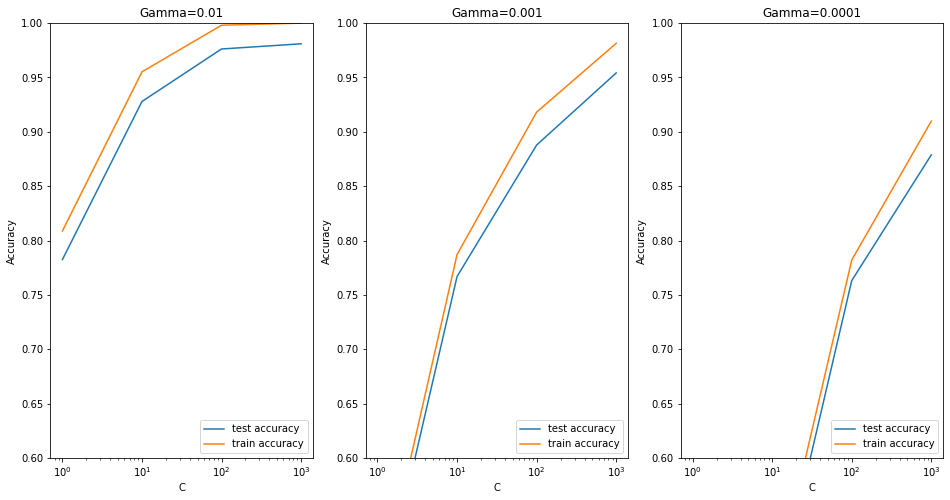

In [ ]:
cv_results['param_C'] = cv_results['param_C'].astype('int')
plt.figure(figsize=(16,8))

plt.subplot(131)
gamma_plots(0.01)

plt.subplot(132)
gamma_plots(0.001)

plt.subplot(133)
gamma_plots(0.0001)

In [ ]:
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("Best score :", best_score)
print("Best Hyperparameters:", best_hyperparams)

Best score : 0.9809762202753441
Best Hyperparameters: {'C': 1000, 'gamma': 0.01}


In [ ]:
model = SVC(C=1000, gamma=0.01, kernel="rbf")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: ")
print(acc*100,"%")
print()

Accuracy: 
82.58333333333333 %

